Here's the markdown explanation:

# Machine Learning Model Selection for Incident Grade Prediction

## Dataset Characteristics
Our analysis revealed that our dataset is entirely categorical in nature:
- Columns that appear numeric (IDs, versions, counts) are actually categorical codes
- No true continuous numeric features exist
- All features represent discrete categories or labels

## Suitable ML Models for Categorical Data

### 1. Tree-Based Models
- **Decision Trees**
  - Naturally handles categorical data
  - No encoding necessary (though can benefit from it)
  - Highly interpretable

- **Random Forest**
  - Ensemble of decision trees
  - Better generalization than single trees
  - Good handling of categorical features

- **Gradient Boosting (LightGBM/XGBoost)**
  - Optimized for categorical features
  - High performance on tabular data
  - Built-in categorical feature support

### 2. Probabilistic Models
- **Categorical Naive Bayes**
  - Specifically designed for categorical features
  - Works well with high-dimensional categorical data
  - Probabilistic predictions

### 3. Other Suitable Models
- **CatBoost**
  - Specifically designed for categorical features
  - Handles categorical features without preprocessing
  - Built-in encoding mechanisms

## Data Preprocessing Requirements
1. **Label Encoding**
   - Convert categorical strings to numeric codes
   - Preserve categorical nature of features
   - Required for most ML libraries

2. **Missing Value Handling**
   - Special category for missing values
   - Maintain categorical nature of data

3. **Feature Selection**
   - Based on Cramer's V correlation
   - Chi-square tests for feature importance
   - Information gain metrics

## Evaluation Metrics
For categorical target (Incident Grade):
1. **Classification Metrics**
   - Accuracy
   - Precision/Recall
   - F1-Score
   - ROC-AUC

2. **Confusion Matrix**
   - Class-wise performance
   - Error analysis

Would you like me to:
1. Add implementation details for each model?
2. Include code examples?
3. Add performance comparison metrics?
4. Elaborate on any specific aspect?


In [1]:
import pandas as pd

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [25]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm

In [4]:
df=pd.read_csv("/Users/lukishyadav/Desktop/Engineering/case_study/ai_strike/data/GUIDE_Train.csv")

In [5]:
# Incident Level
incident_columns = {
    'id_columns': [
        'Id',          # System-generated identifier
        'OrgId',       # "Organization identifier"
        'IncidentId'   # "Organizationally unique incident identifier"
    ],
    'num_features': [],
    'cat_features': [],
    'target': [
        'IncidentGrade'  # "SOC grade assigned to the incident"
                        # BenignPositive: 43.20%
                        # TruePositive: 34.91%
                        # FalsePositive: 21.35%
    ]
}

# Alert Level
alert_columns = {
    'id_columns': [
        'AlertId'      # "Unique identifier for an alert"
    ],
    'num_features': [
        'Timestamp'    # "Time the alert was created"
    ],
    'cat_features': [
        # Low Null Rate Features
        'DetectorId',      # "Unique ID for the alert generating detector"
        'AlertTitle',      # "Title of the alert"
        'Category',        # "Category of the alert"
        
        # Moderate Null Rate Features
        'MitreTechniques'  # "MITRE ATT&CK techniques involved in alert"
    ],
    'target': [
        'ActionGrouped',   # "SOC alert remediation action (high level)"
        'ActionGranular'   # "SOC alert remediation action (fine-grain)"
    ]
}

# Evidence Level
evidence_columns = {
    'id_columns': [
        'DeviceId',           # "Unique identifier for the device"
        'NetworkMessageId'    # "Org-level identifier for email message"
    ],
    'num_features': [
        'OSVersion',          # "Version of the operating system"
        'CountryCode',        # "Country code evidence appears in"
        'State',              # "State of evidence appears in"
        'City'               # "City evidence appears in"
    ],
    'cat_features': [
        # Low Null Rate Features (<20%)
        'EntityType',         # "Type of entity involved in the alert"
        'EvidenceRole',       # "Role of the evidence in the investigation"
        'OSFamily',           # "Family of the operating system"
        'DeviceName',         # "Name of the device"
        'AccountName',        # Account display name
        'IpAddress',          # "IP address involved"
        
        # Medium Null Rate Features (20-50%)
        'Url',               # "URL involved"
        'AccountUpn',        # "Email account identifier"
        'Sha256',            # "SHA-256 hash of the file"
        'ApplicationName',    # "Name of the application"
        
        # High Null Rate Features (>90%)
        'EmailClusterId',     # "Unique identifier for the email cluster"
        'ThreatFamily',       # "Malware family associated with a file"
        'ResourceType',       # "Type of Azure resource"
        'Roles',             # "Additional metadata on evidence role in alert"
        'AntispamDirection',  # "Direction of the antispam filter"
        'RegistryKey',        # "Registry key involved"
        'RegistryValueName',  # "Name of the registry value"
        'RegistryValueData',  # "Data of the registry value"
        'FileName',          # "Name of the file"
        'FolderPath',        # "Path of the file folder"
        'ResourceIdName'     # "Name of the Azure resource"
    ],
    'target': [
        'SuspicionLevel',   # "Level of suspicion"
        'LastVerdict'      # "Final verdict of threat analysis"
    ]
}

# Forming features and targets

In [9]:
# Combine all features (excluding IDs and targets)
features = (
    alert_columns['cat_features'] + 
    alert_columns['num_features'] +  # These are actually categorical
    evidence_columns['cat_features'] + 
    evidence_columns['num_features']  # These are actually categorical
)

# Get all ID columns to exclude
id_columns = (
    incident_columns['id_columns'] +
    alert_columns['id_columns'] +
    evidence_columns['id_columns']
)

# Get all target columns
target_columns = (
    incident_columns['target'] +
    alert_columns['target'] +
    evidence_columns['target']
)

print("Feature Summary:")
print(f"Total features selected: {len(features)}")
print("Features:", features)
print(f"\nID columns excluded: {len(id_columns)}")
print("ID columns:", id_columns)
print(f"\nTarget columns: {len(target_columns)}")
print("Target columns:", target_columns)

Feature Summary:
Total features selected: 30
Features: ['DetectorId', 'AlertTitle', 'Category', 'MitreTechniques', 'Timestamp', 'EntityType', 'EvidenceRole', 'OSFamily', 'DeviceName', 'AccountName', 'IpAddress', 'Url', 'AccountUpn', 'Sha256', 'ApplicationName', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'FileName', 'FolderPath', 'ResourceIdName', 'OSVersion', 'CountryCode', 'State', 'City']

ID columns excluded: 6
ID columns: ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DeviceId', 'NetworkMessageId']

Target columns: 5
Target columns: ['IncidentGrade', 'ActionGrouped', 'ActionGranular', 'SuspicionLevel', 'LastVerdict']


# Null values analysis


In [11]:
def analyze_null_values():
    # Combine features and targets for analysis
    all_columns = features + target_columns
    
    # Calculate null statistics
    null_stats = pd.DataFrame({
        'Total_Rows': len(df),
        'Null_Count': df[all_columns].isnull().sum(),
        'Null_Percentage': (df[all_columns].isnull().sum() / len(df) * 100).round(2)
    }).sort_values('Null_Percentage', ascending=False)
    
    # Add column type classification
    null_stats['Column_Type'] = null_stats.index.map(
        lambda x: 'Target' if x in target_columns else 'Feature'
    )
    
    # Print summary
    print("Null Value Analysis:")
    print("=" * 80)
    print("\nColumns with null values (sorted by percentage):")
    print(null_stats[null_stats['Null_Count'] > 0])
    
    print("\nSummary by Column Type:")
    print("-" * 40)
    for col_type in ['Feature', 'Target']:
        type_stats = null_stats[null_stats['Column_Type'] == col_type]
        print(f"\n{col_type} Columns:")
        print(f"Total columns: {len(type_stats)}")
        print(f"Columns with nulls: {len(type_stats[type_stats['Null_Count'] > 0])}")
        if len(type_stats) > 0:
            print(f"Average null percentage: {type_stats['Null_Percentage'].mean():.2f}%")
    
    # Visualize null percentages
    import plotly.express as px
    
    # Create bar plot
    fig = px.bar(
        null_stats[null_stats['Null_Count'] > 0],
        x=null_stats[null_stats['Null_Count'] > 0].index,
        y='Null_Percentage',
        color='Column_Type',
        title='Null Percentages by Column',
        labels={'index': 'Column Name', 'Null_Percentage': 'Null Percentage (%)'}
    )
    
    fig.update_layout(
        xaxis_tickangle=-45,
        showlegend=True,
        height=600
    )
    
    fig.show()
    
    return null_stats

# Run the analysis
null_stats = analyze_null_values()

Null Value Analysis:

Columns with null values (sorted by percentage):
                   Total_Rows  Null_Count  Null_Percentage Column_Type
ResourceType          9516837     9509762            99.93     Feature
ActionGranular        9516837     9460773            99.41      Target
ActionGrouped         9516837     9460773            99.41      Target
ThreatFamily          9516837     9441956            99.21     Feature
EmailClusterId        9516837     9420025            98.98     Feature
AntispamDirection     9516837     9339535            98.14     Feature
Roles                 9516837     9298686            97.71     Feature
SuspicionLevel        9516837     8072708            84.83      Target
LastVerdict           9516837     7282572            76.52      Target
MitreTechniques       9516837     5468386            57.46     Feature
IncidentGrade         9516837       51340             0.54      Target

Summary by Column Type:
----------------------------------------

Feature Co

In [12]:
# Get null value analysis for features
feature_nulls = pd.DataFrame({
    'Total_Rows': len(df),
    'Null_Count': df[features].isnull().sum(),
    'Null_Percentage': (df[features].isnull().sum() / len(df) * 100).round(2)
}).sort_values('Null_Percentage', ascending=False)

# Get null value analysis for targets
target_nulls = pd.DataFrame({
    'Total_Rows': len(df),
    'Null_Count': df[target_columns].isnull().sum(),
    'Null_Percentage': (df[target_columns].isnull().sum() / len(df) * 100).round(2)
}).sort_values('Null_Percentage', ascending=False)

print("Features with Null Values:")
print("=" * 50)
print(feature_nulls[feature_nulls['Null_Count'] > 0])

print("\nTargets with Null Values:")
print("=" * 50)
print(target_nulls[target_nulls['Null_Count'] > 0])

# Create lists of features with nulls
features_with_nulls = feature_nulls[feature_nulls['Null_Count'] > 0].index.tolist()
targets_with_nulls = target_nulls[target_nulls['Null_Count'] > 0].index.tolist()

print("\nSummary:")
print(f"Features with nulls: {len(features_with_nulls)}")
print(f"Targets with nulls: {len(targets_with_nulls)}")

Features with Null Values:
                   Total_Rows  Null_Count  Null_Percentage
ResourceType          9516837     9509762            99.93
ThreatFamily          9516837     9441956            99.21
EmailClusterId        9516837     9420025            98.98
AntispamDirection     9516837     9339535            98.14
Roles                 9516837     9298686            97.71
MitreTechniques       9516837     5468386            57.46

Targets with Null Values:
                Total_Rows  Null_Count  Null_Percentage
ActionGrouped      9516837     9460773            99.41
ActionGranular     9516837     9460773            99.41
SuspicionLevel     9516837     8072708            84.83
LastVerdict        9516837     7282572            76.52
IncidentGrade      9516837       51340             0.54

Summary:
Features with nulls: 6
Targets with nulls: 5


# Observing disctinct values of features and targets with null values so that we can see if they are to be repaced/filled or columns are to be dropped

In [19]:
# Get distinct values for each column with nulls
print("Distinct Values Analysis for Columns with Nulls:")
print("=" * 80)

for column in features_with_nulls + targets_with_nulls:
    print(f"\nColumn: {column}")
    print("-" * 40)
    
    # Get value counts including nulls
    value_counts = df[column].value_counts(dropna=False)
    
    print(f"Total distinct values: {df[column].nunique()}")
    print(f"Null count: {df[column].isnull().sum()}")
    print(f"Null percentage: {(df[column].isnull().sum() / len(df) * 100):.2f}%")
    print("\nValue distribution:")
    print(value_counts)
    print("-" * 80)

# Optional: Create a summary DataFrame
summary_df = pd.DataFrame({
    'Column': features_with_nulls + targets_with_nulls,
    'Distinct_Values': [df[col].nunique() for col in features_with_nulls + targets_with_nulls],
    'Null_Count': [df[col].isnull().sum() for col in features_with_nulls + targets_with_nulls],
    'Null_Percentage': [(df[col].isnull().sum() / len(df) * 100).round(2) for col in features_with_nulls + targets_with_nulls]
})

print("\nSummary of Distinct Values:")
print(summary_df.sort_values('Null_Percentage', ascending=False))

Distinct Values Analysis for Columns with Nulls:

Column: ResourceType
----------------------------------------
Total distinct values: 25
Null count: 9509762
Null percentage: 99.93%

Value distribution:
ResourceType
NaN                                     9509762
Virtual Machine                            4146
Key Vault                                   480
App Service                                 404
Azure Arc machine                           373
Storage Account                             366
Subscription                                271
SQL Database                                226
Azure Database for MySQL Server             182
Azure Resource                              157
Virtual Machine Scale Set                   112
API Management Service                       94
Key Vault Secret                             77
Azure Database for PostgreSQL Server         45
SQL Server                                   41
Azure Cosmos DB Account                      30
Networking      

# Dropping null incident records

In [20]:
# First, drop records with null incident grade
df_clean = df[df['IncidentGrade'].notna()].copy()
print(f"Original dataset size: {len(df)}")
print(f"Dataset size after dropping null IncidentGrade: {len(df_clean)}")


Original dataset size: 9516837
Dataset size after dropping null IncidentGrade: 9465497


# Lack of time for us

In [31]:
# First, drop records with null incident grade
df_clean = df[df['IncidentGrade'].notna()].copy()

# Print original class distribution
print("Original class distribution:")
print(df_clean['IncidentGrade'].value_counts(normalize=True))

# Take stratified sample
n_samples = 1000  # total samples we want
n_each_class = n_samples // len(df_clean['IncidentGrade'].unique())  # samples per class

# Sample equal numbers from each class
df_balanced = pd.DataFrame()
for grade in df_clean['IncidentGrade'].unique():
    class_sample = df_clean[df_clean['IncidentGrade'] == grade].sample(n=n_each_class, random_state=42)
    df_balanced = pd.concat([df_balanced, class_sample])

# Shuffle the final dataset
df_clean = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Print new class distribution
print("\nBalanced class distribution:")
print(df_clean['IncidentGrade'].value_counts(normalize=True))

print(f"\nFinal dataset size: {len(df_clean)}")

Original class distribution:
IncidentGrade
BenignPositive    0.434295
TruePositive      0.351034
FalsePositive     0.214671
Name: proportion, dtype: float64

Balanced class distribution:
IncidentGrade
FalsePositive     0.333333
BenignPositive    0.333333
TruePositive      0.333333
Name: proportion, dtype: float64

Final dataset size: 999


# Training Cat boost with and with null features (dropping vs replacing nullsm)


=== Method 1: Training with Dropped Features ===

Features retained: 24
Features dropped: 6

Dropped features: ['ResourceType', 'ThreatFamily', 'EmailClusterId', 'AntispamDirection', 'Roles', 'MitreTechniques']

=== Method 2: Training with All Features (Nulls replaced with 'UNKNOWN') ===

Total features used: 30

Results for Dropped Features Method:
Number of features used: 24
Accuracy: 0.6700
ROC AUC: 0.8156

Classification Report:
                precision    recall  f1-score   support

BenignPositive       0.61      0.83      0.71        66
 FalsePositive       0.74      0.46      0.57        67
  TruePositive       0.71      0.72      0.71        67

      accuracy                           0.67       200
     macro avg       0.69      0.67      0.66       200
  weighted avg       0.69      0.67      0.66       200



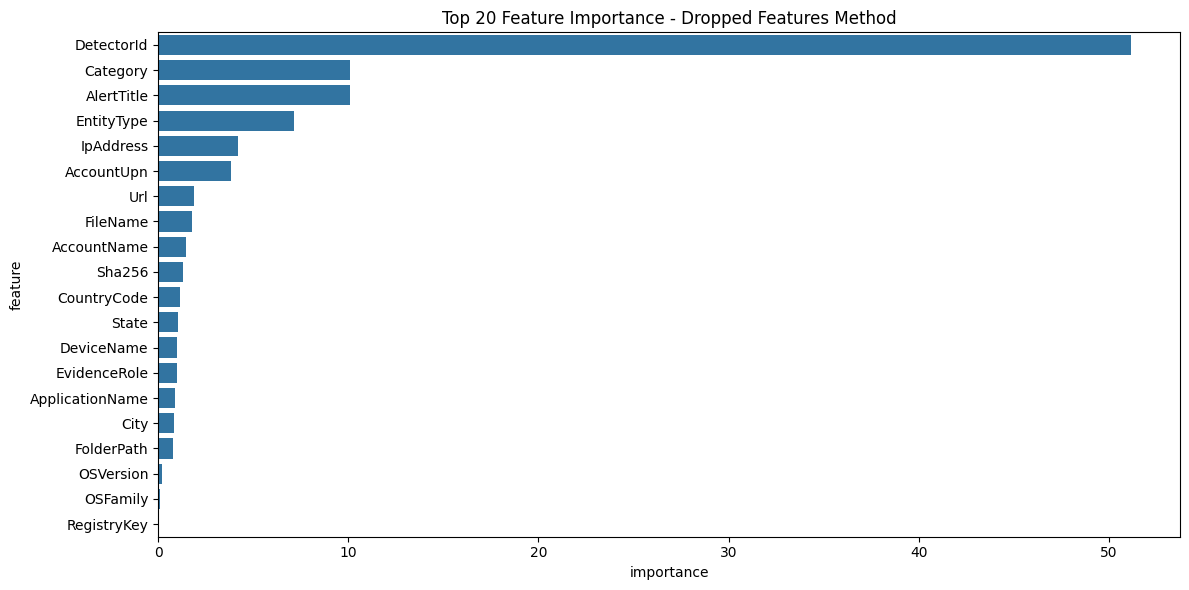


Results for All Features Method:
Number of features used: 30
Accuracy: 0.6800
ROC AUC: 0.8094

Classification Report:
                precision    recall  f1-score   support

BenignPositive       0.62      0.83      0.71        66
 FalsePositive       0.74      0.51      0.60        67
  TruePositive       0.72      0.70      0.71        67

      accuracy                           0.68       200
     macro avg       0.69      0.68      0.67       200
  weighted avg       0.69      0.68      0.67       200



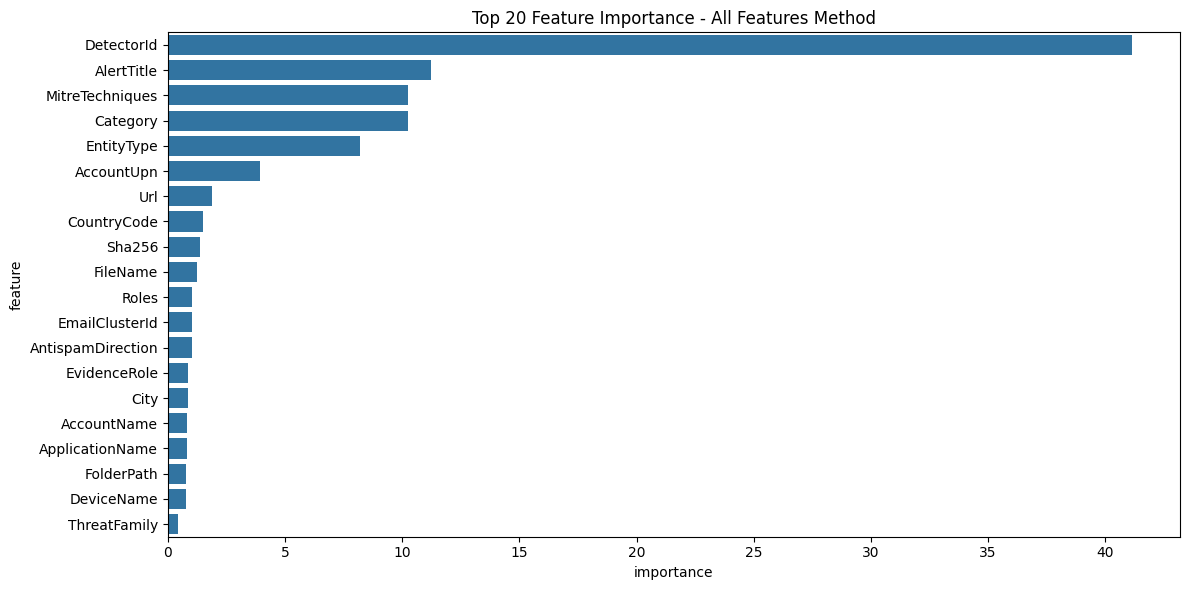


Final Comparison:
             Method  Accuracy   ROC AUC  Number of Features
0  Dropped Features      0.67  0.815560                  24
1      All Features      0.68  0.809437                  30


<Figure size 1000x600 with 0 Axes>

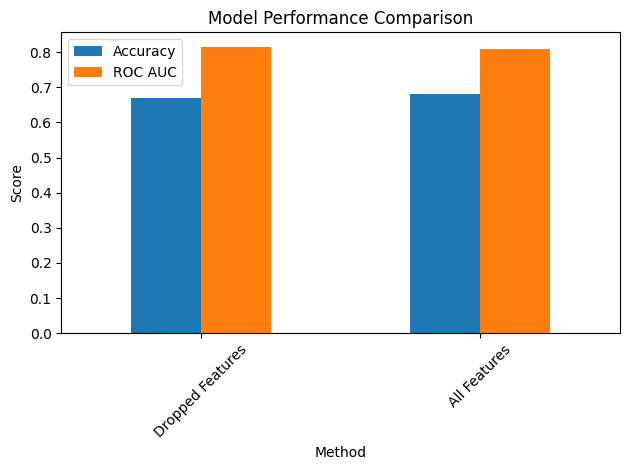

In [33]:
# Method 1: Drop features that have nulls
def train_with_dropped_features():
    print("\n=== Method 1: Training with Dropped Features ===")
    
    # Get features without nulls (drop all features that have any nulls)
    features_without_nulls = [f for f in features if f not in features_with_nulls]
    print(f"\nFeatures retained: {len(features_without_nulls)}")
    print(f"Features dropped: {len(features_with_nulls)}")
    print("\nDropped features:", features_with_nulls)
    
    # Prepare data
    X = df_clean[features_without_nulls].astype(str)  # Convert all features to strings
    y = df_clean['IncidentGrade']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Create CatBoost Pool with categorical features
    cat_features = list(range(X.shape[1]))
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    test_pool = Pool(X_test, y_test, cat_features=cat_features)
    
    # Train model
    model = CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        loss_function='MultiClass',
        random_seed=42,
        verbose=False
    )
    
    model.fit(train_pool)
    
    return model, test_pool, X, y

# Method 2: Keep all features but replace nulls with 'UNKNOWN'
def train_with_all_features():
    print("\n=== Method 2: Training with All Features (Nulls replaced with 'UNKNOWN') ===")
    
    # Prepare data - keep all features but replace nulls and convert to string
    X = df_clean[features].fillna('UNKNOWN').astype(str)  # Convert all features to strings
    y = df_clean['IncidentGrade']
    
    print(f"\nTotal features used: {len(features)}")
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Create CatBoost Pool with categorical features
    cat_features = list(range(X.shape[1]))
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    test_pool = Pool(X_test, y_test, cat_features=cat_features)
    
    # Train model
    model = CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        loss_function='MultiClass',
        random_seed=42,
        verbose=False
    )
    
    model.fit(train_pool)
    
    return model, test_pool, X, y

# Train both models
model1, test_pool1, X1, y1 = train_with_dropped_features()
model2, test_pool2, X2, y2 = train_with_all_features()

# Evaluate both models
def evaluate_model(model, test_pool, X, name):
    y_pred = model.predict(test_pool)
    y_pred_proba = model.predict_proba(test_pool)
    
    # Get actual test labels
    y_test = test_pool.get_label()
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    
    print(f"\nResults for {name}:")
    print(f"Number of features used: {X.shape[1]}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Feature importance
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance_df.head(20), x='importance', y='feature')
    plt.title(f'Top 20 Feature Importance - {name}')
    plt.tight_layout()
    plt.show()
    
    return accuracy, roc_auc, importance_df

# Evaluate both approaches
acc1, roc1, imp1 = evaluate_model(model1, test_pool1, X1, "Dropped Features Method")
acc2, roc2, imp2 = evaluate_model(model2, test_pool2, X2, "All Features Method")

# Compare results
comparison_df = pd.DataFrame({
    'Method': ['Dropped Features', 'All Features'],
    'Accuracy': [acc1, acc2],
    'ROC AUC': [roc1, roc2],
    'Number of Features': [X1.shape[1], X2.shape[1]]
})

print("\nFinal Comparison:")
print(comparison_df)

# Plot comparison
plt.figure(figsize=(10, 6))
comparison_df.set_index('Method')[['Accuracy', 'ROC AUC']].plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()